# Geospatial Image Classification with Deep Learning - PyTorch
## End‑to‑End Satellite Image Analysis using CNNs and Vision Transformers

## Table of Contents

[The Dataset](#The-Dataset)

[The Required Libraries and Environment Settings](#The-Required-Libraries-and-Environment-Settings)
   - [The Required Libraries](#The-Required-Libraries)
   - [Set Random Seed for Reproducibility](#Set-Random-Seed-for-Reproducibility)
   - [Check GPU Availability](#Check-GPU-Availability)
   - [Define Data Folder Path](#Define-Data-Folder-Path)
   - [Load The Full Dataset Using ImageFolder](#Load-The-Full-Dataset-Using-ImageFolder)
   - [Dataset Splitting](#Dataset-Splitting)

[Model Hyperparameters](#Model-Hyperparameters)

[Create Data Transforms for Augmentation Pipeline](#Create-Data-Transforms-for-Augmentation-Pipeline)

[Create Training and Validation DataLoaders](#Create-Training-and-Validation-DataLoaders)

[Model Definition](#Model-Definition)

[Model Compilation](#Model-Compilation)

[Training Setup](#Training-Setup)

[Model Training](#Model-Training)

[Model Evaluation](#Model-Evaluation)
   - [Training and Validation Curves](#Training-and-Validation-Curves)    


## The Dataset

The dataset contains 6,000 color satellite images, each resized to 64×64 pixels and labeled for a binary land‑use classification task. Every image belongs to one of two categories:

- ``class_0_non_agri``: regions without agricultural activity (e.g., forests, urban regions, water bodies, barren land).

- ``class_1_agri``: areas showing agricultural structures such as crop fields or structured farmland.

The images are evenly distributed across both classes and exhibit natural variability in geographic context. This diversity helps the model generalize to different environmental conditions and reduces overfitting to specific visual patterns.

All images are RGB and share the same spatial resolution and are preprocessed into a consistent format suitable for convolutional neural networks. The dataset provides a solid foundation for training and evaluating models aimed at automated agricultural land‑use detection.

## The Required Libraries and Environment Settings

### The Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
import json
import os
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

### Set Random Seed for Reproducibility  

In [4]:
def set_seed(seed = 62):
    # Python random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set to {seed}")

In [5]:
SEED = 62
set_seed(SEED)

Random seed set to 62


It is important to define `worker_init_fn()` because every DataLoader worker in PyTorch runs in its own separate process, each with its own independent random‑number generators. If we don’t explicitly re‑seed those workers, they all inherit the same RNG (Random Number Generator) state, which leads to nondeterministic behavior in shuffling, batching, and data augmentation. By giving each worker a unique, reproducible seed, we ensure that every run of our training pipeline produces the same sequence of batches and the same random transformations. This closes one of the biggest gaps in PyTorch reproducibility and brings its behavior much closer to the consistency we’re used to from TensorFlow’s more tightly controlled data pipeline.

In [6]:
def worker_init_fn(worker_id):
    """Ensure each DataLoader worker has a unique, reproducible seed."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

### Check GPU Availability

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())

Using device: cpu


### Define Data Folder Path

In [8]:
data_path = os.path.join(".", "data") 
print("Data folder path:", data_path)

Data folder path: .\data


### Load the full dataset using ``ImageFolder``

In [9]:
full_dataset = datasets.ImageFolder(
    root= data_path,
    # we apply transforms AFTER splitting
    transform= None   
)

### Dataset Splitting 

In [10]:
targets = full_dataset.targets  # class indices

train_idx, val_idx = train_test_split(
    list(range(len(targets))),
    test_size= 0.2,
    stratify= targets,
    random_state= SEED,
)

In [11]:
full_counts  = Counter(targets)
train_counts = Counter([targets[i] for i in train_idx])
val_counts   = Counter([targets[i] for i in val_idx])

print(
    f"\n========= Dataset Class Distribution =========\n\n"
    f"Full Dataset:      {full_counts}\n"
    f"Training Split:    {train_counts}\n"
    f"Validation Split:  {val_counts}\n\n"
    f"==============================================\n"
)


========= Dataset Class Distribution =========

Full Dataset:      Counter({0: 3000, 1: 3000})
Training Split:    Counter({0: 2400, 1: 2400})
Validation Split:  Counter({0: 600, 1: 600})




## Model Hyperparameters

Use a batch size that evenly divides both the number of validation samples and the number of training samples to prevent partial batches.



In [12]:
# Model hyperparameters
img_w, img_h = 64, 64
n_channels = 3     # Number of image channels (3 for RGB)
n_classes = 2      # Number of output classes

batch_size = 120
lr = 1e-3           # Learning rate
n_epochs = 15       # Number of epochs

model_name = "pytorch_model"

## Create Data Transforms for Augmentation Pipeline

In [13]:
# ImageNet normalization values
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [14]:
train_transform = transforms.Compose([
    # Resize every input image to the exact width and height
    transforms.Resize((img_w, img_h)),
    transforms.RandomRotation(25),
    transforms.RandomAffine(
        degrees= 0,
        translate= (0.2, 0.2),   # width_shift_range & height_shift_range
        shear= 20,               # shear_range
        scale= (0.8, 1.2)        # zoom_range
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Convert to [0,1] automatically
    transforms.ToTensor(),       
    transforms.Normalize(
        mean= IMAGENET_MEAN,
        std= IMAGENET_STD
    ),
])

In [15]:
val_transform = transforms.Compose([
    # PyTorch uses (h, w)
    transforms.Resize((img_h, img_w)),   
    transforms.ToTensor(),
    transforms.Normalize(
        mean= IMAGENET_MEAN,
        std= IMAGENET_STD
    ),
])

In [16]:
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

# Assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

## Create Training and Validation ``DataLoader``

In [17]:
print("CPU cores available:", os.cpu_count())

CPU cores available: 12


In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size= batch_size,
    shuffle= True,
    num_workers= 0,   # 0 is Windows-safe 
    worker_init_fn= worker_init_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size= batch_size,
    shuffle= False,
    num_workers= 0,  # 0 is Windows-safe
    worker_init_fn= worker_init_fn 
)

> Why ``shuffle=True`` for training but ``shuffle=False`` for validation

Shuffling is enabled for the training generator because the model should see 
the data in a different order in each epoch to improve generalization and to reduce overfitting, while the validation generator keeps ``shuffle=False`` so evaluation remains stable and deterministic. Even with a fixed seed, shuffling the validation set is still discouraged because the goal of validation is stable, repeatable evaluation. A seed only guarantees that the shuffle order is the same each run, but the order would still change every epoch.

For ``flow_from_directory``, the default value of ``shuffle`` is ``True``.

## Model Definition

In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=1):
        super(CNNModel, self).__init__()

        # --- Convolution Blocks ---
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(512)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(1024)
        )

        # --- Global Average Pooling ---
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # --- Dense Layers ---
        self.fc = nn.Sequential(
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),

            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),

            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),

            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.4),

            nn.Linear(2048, num_classes)  # logits
        )

        # --- Apply He Initialization ---
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x


In [20]:
# Instantiate model
model = CNNModel(num_classes= 1).to(device)

## Model Compilation

In [21]:
# Loss function (binary classification)
# because our model ends with Sigmoid()
# criterion = nn.BCELoss()   
# criterion = nn.CrossEntropyLoss()

# Loss for binary classification
criterion = nn.BCEWithLogitsLoss()   
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
total_layers = sum(1 for _ in model.modules())
print(f"Total nn.Module layers: {total_layers}")

Total nn.Module layers: 58


In [23]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
       BatchNorm2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 64, 112, 112]          51,264
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 128, 56, 56]         204,928
             ReLU-10          [-1, 128, 56, 56]               0
        MaxPool2d-11          [-1, 128, 28, 28]               0
      BatchNorm2d-12          [-1, 128, 28, 28]             256
           Conv2d-13          [-1, 256, 28, 28]         819,456
             ReLU-14          [-1, 256,

## Training Setup

In [24]:
# ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode= 'min',
    factor= 0.2,
    patience= 3
)

## Model Training

In [25]:
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

In [26]:
train_targets = np.array(full_dataset.targets)[train_idx]
n_classes_train = len(np.unique(train_targets))

val_targets = np.array(full_dataset.targets)[val_idx]
n_classes_val = len(np.unique(val_targets))

In [27]:
# ====================== Training Overview ======================

print(
    f"\n"
    f"================ Training Hyperparameters ================\n"
    f"  Device:                   {device}\n"
    f"  n_classes (train):        {n_classes_train}\n"
    f"  n_classes (validation):   {n_classes_val}\n"
    f"  Image Size:               ({img_w}, {img_h})\n"
    f"  n_channels:               {n_channels}\n"
    f"  batch_size:               {batch_size}\n"
    f"  steps_per_epoch:          {steps_per_epoch}\n"
    f"  validation_steps:         {validation_steps}\n"
    f"  n_epochs:                 {n_epochs}\n"
    f"  learning_rate:            {lr}\n"
    f"=========================================================="
)



================ Training Hyperparameters ================
  Device:                   cpu
  n_classes (train):        2
  n_classes (validation):   2
  Image Size:               (64, 64)
  n_channels:               3
  batch_size:               120
  steps_per_epoch:          40
  validation_steps:         10
  n_epochs:                 15
  learning_rate:            0.001


In [28]:
%%time

# ==== Fit Model on Training Data ====
# ------------------------------------

# Histories
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

for epoch in range(n_epochs):

    # -------------------------
    # Training Phase
    # -------------------------
    start_time = time.time()
    model.train()

    train_loss, train_correct, train_total = 0, 0, 0

    for batch_idx, (images, labels) in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    ):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)  # raw logits, shape [B, 1]

        # BCEWithLogitsLoss expects float targets with same shape
        loss = criterion(outputs, labels.float().unsqueeze(1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Predictions: apply sigmoid → threshold at 0.5
        preds = (torch.sigmoid(outputs) > 0.5).long()

        train_correct += (preds.squeeze(1) == labels).sum().item()
        train_total += labels.size(0)

    if device == 'cuda':
        torch.cuda.synchronize()

    # -------------------------
    # Validation Phase
    # -------------------------
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).long()
            val_correct += (preds.squeeze(1) == labels).sum().item()
            val_total += labels.size(0)

    # -------------------------
    # Save best model
    # -------------------------
    avg_val_loss = val_loss / len(val_loader)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), model_name + ".pth")

    # -------------------------
    # Store metrics
    # -------------------------
    loss_history['train'].append(train_loss / len(train_loader))
    loss_history['val'].append(val_loss / len(val_loader))
    acc_history['train'].append(train_correct / train_total)
    acc_history['val'].append(val_correct / val_total)

    # -------------------------
    # Logging
    # -------------------------
    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc:  {acc_history['train'][-1]:.4f} | Val Acc:  {acc_history['val'][-1]:.4f}")

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds\n")


Epoch 1/15: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


Train Loss: 0.2790 | Val Loss: 0.0123
Train Acc:  0.8958 | Val Acc:  0.9950
Epoch 1 training completed in 32.46 seconds



Epoch 2/15: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


Train Loss: 0.1012 | Val Loss: 0.0188
Train Acc:  0.9762 | Val Acc:  0.9933
Epoch 2 training completed in 28.91 seconds



Epoch 3/15: 100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Train Loss: 0.0787 | Val Loss: 0.0073
Train Acc:  0.9808 | Val Acc:  0.9975
Epoch 3 training completed in 30.99 seconds



Epoch 4/15: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


Train Loss: 0.0463 | Val Loss: 0.0255
Train Acc:  0.9881 | Val Acc:  0.9917
Epoch 4 training completed in 29.85 seconds



Epoch 5/15: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


Train Loss: 0.0428 | Val Loss: 0.0413
Train Acc:  0.9894 | Val Acc:  0.9850
Epoch 5 training completed in 31.42 seconds



Epoch 6/15: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Train Loss: 0.0354 | Val Loss: 0.0123
Train Acc:  0.9917 | Val Acc:  0.9967
Epoch 6 training completed in 30.80 seconds



Epoch 7/15: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Train Loss: 0.0440 | Val Loss: 0.0219
Train Acc:  0.9896 | Val Acc:  0.9925
Epoch 7 training completed in 30.88 seconds



Epoch 8/15: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Train Loss: 0.0298 | Val Loss: 0.0072
Train Acc:  0.9908 | Val Acc:  0.9975
Epoch 8 training completed in 30.86 seconds



Epoch 9/15: 100%|██████████| 40/40 [00:27<00:00,  1.48it/s]


Train Loss: 0.0310 | Val Loss: 0.0270
Train Acc:  0.9929 | Val Acc:  0.9917
Epoch 9 training completed in 29.47 seconds



Epoch 10/15: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


Train Loss: 0.0424 | Val Loss: 0.0133
Train Acc:  0.9881 | Val Acc:  0.9933
Epoch 10 training completed in 29.08 seconds



Epoch 11/15: 100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Train Loss: 0.0268 | Val Loss: 0.0059
Train Acc:  0.9925 | Val Acc:  0.9992
Epoch 11 training completed in 31.35 seconds



Epoch 12/15: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


Train Loss: 0.0128 | Val Loss: 0.0067
Train Acc:  0.9960 | Val Acc:  0.9975
Epoch 12 training completed in 31.69 seconds



Epoch 13/15: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


Train Loss: 0.0230 | Val Loss: 0.0083
Train Acc:  0.9946 | Val Acc:  0.9975
Epoch 13 training completed in 32.04 seconds



Epoch 14/15: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Train Loss: 0.0189 | Val Loss: 0.0139
Train Acc:  0.9950 | Val Acc:  0.9950
Epoch 14 training completed in 30.54 seconds



Epoch 15/15: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


Train Loss: 0.0204 | Val Loss: 0.0056
Train Acc:  0.9958 | Val Acc:  0.9983
Epoch 15 training completed in 31.24 seconds

CPU times: total: 45min 34s
Wall time: 7min 41s


**Wall time** → the actual time we waited in the notebook — the time on the clock.

**CPU time** → the sum of all CPU core time used. If 6 CPU cores each work for 7.5 minutes then CPU time ≈ 45 minutes

In [ ]:
history = {
    "train_loss": loss_history["train"],
    "val_loss": loss_history["val"],
    "train_acc": acc_history["train"],
    "val_acc": acc_history["val"]
}

with open(model_name + "-training_history.json", "w") as f:
    json.dump(history, f, indent= 4)

print("Training history saved to " + model_name + "-training_history.json")

Training history saved to pytorch_model-training_history.json


## Model Evaluation

In [27]:
model = CNNModel(num_classes= 1)
model.load_state_dict(torch.load(model_name + ".pth", map_location= device))
model.to(device)
model.eval()

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()


In [28]:
def evaluate_model(model, loader, device):
    """
    Evaluate a trained PyTorch model on a given DataLoader.
    Computes accuracy, confusion matrix, and classification report.
    """

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)              # raw logits [B,1]
            probs = torch.sigmoid(outputs)       # convert to probabilities
            preds = (probs > 0.5).long().cpu()   # threshold at 0.5

            all_preds.extend(preds.squeeze(1).tolist())
            all_labels.extend(labels.cpu().tolist())

    # --- Detailed metrics ---
    print("\n=== Detailed Metrics ===")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

In [29]:
evaluate_model(model, val_loader, device)


=== Detailed Metrics ===
Accuracy: 0.9983

Confusion Matrix:
[[599   1]
 [  1 599]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9983    0.9983       600
           1     0.9983    0.9983    0.9983       600

    accuracy                         0.9983      1200
   macro avg     0.9983    0.9983    0.9983      1200
weighted avg     0.9983    0.9983    0.9983      1200



### Training and Validation Curves

In [30]:
with open(model_name + "-training_history.json", "r") as f:
    hist_data = json.load(f)

print(hist_data.keys())

dict_keys(['train_loss', 'val_loss', 'train_acc', 'val_acc'])


In [ ]:
def plot_training_history(history_data):
    """Plot training and validation accuracy/loss curves with best epoch markers."""

    # Extract metrics using PyTorch naming
    acc = history_data.get("train_acc")
    val_acc = history_data.get("val_acc")
    loss = history_data.get("train_loss")
    val_loss = history_data.get("val_loss")

    # Safety check
    if acc is None or val_acc is None or loss is None or val_loss is None:
        raise ValueError("History JSON does not contain expected keys.")

    epochs = range(1, len(acc) + 1)

    # Best validation accuracy epoch
    best_acc_epoch = val_acc.index(max(val_acc)) + 1

    # Minimum validation loss epoch
    best_loss_epoch = val_loss.index(min(val_loss)) + 1

    plt.figure(figsize=(7, 7))

    # =====================
    # --- Accuracy plot ---
    # =====================
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label="Training Accuracy", color="green")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="darkred")

    plt.scatter(
        best_acc_epoch, 
        val_acc[best_acc_epoch - 1], 
        color= "darkred", 
        s= 50    # point size
        )
    plt.text(best_acc_epoch,
             # Shift downward
             val_acc[best_acc_epoch - 1] - 0.02,
             f"Max Val Acc\nEpoch: {best_acc_epoch}",
             color= "darkred",
             fontsize= 7,
             # Center horizontally under the point
             ha= "center")

    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # =================
    # --- Loss plot ---
    # =================
    plt.subplot(2, 1, 2)
    plt.plot(epochs, 
             loss, 
             label= "Training Loss", 
             color= "green")
    plt.plot(epochs, 
             val_loss, 
             label= "Validation Loss", 
             color= "darkred")

    # The point for minimum validation loss
    plt.scatter(best_loss_epoch, 
                val_loss[best_loss_epoch - 1], 
                color= "darkred", 
                s= 50)
    plt.text(best_loss_epoch,
             val_loss[best_loss_epoch - 1] + 0.02,
             f"Min Val Loss\nEpoch: {best_loss_epoch}",
             color= "darkred",
             fontsize= 7,
             ha= "center")

    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()


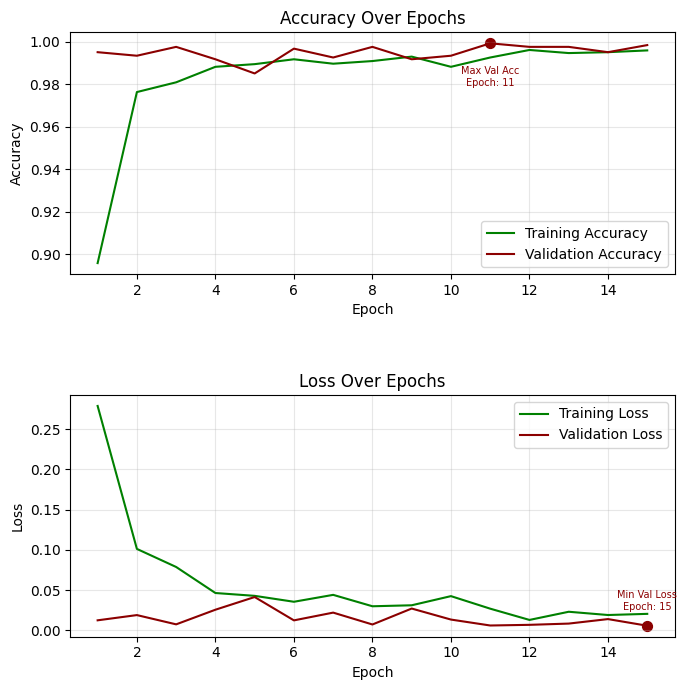

In [42]:
plot_training_history(hist_data)

The model achieved its highest validation accuracy at epoch 11,
while the minimum validation loss occurred at epoch 15, which was used for model selection.